In [18]:
import pandas as pd
from translate.storage.tmx import tmxfile
import warnings
from tqdm import tqdm
import missingno as msno
warnings.filterwarnings('ignore')

In [ ]:
# Data available at https://opus.nlpl.eu/OpenSubtitles-v2018.php
# https://opus.nlpl.eu/download.php?f=OpenSubtitles/v2018/tmx/en-pt.tmx.gz
with open("../../data/en-pt.tmx", 'rb') as fin:
    tmx_file = tmxfile(fin, 'en', 'pt')

In [ ]:
# put tmx file into a pandas dataframe
df = pd.DataFrame(columns=['source', 'target'])
for unit in tmx_file.units:
    df = df.append({'source': unit.source, 'target': unit.target}, ignore_index=True)
df

In [ ]:
df

In [ ]:
# Save it to save time
df.to_csv("../../data/corpus/en-pt.tsv", index=False, sep='\t')

In [ ]:
# Load it
df = pd.read_csv("../../data/corpus/en-pt.tsv", sep='\t')
df

In [ ]:
# Create a smaller dataset for testing
df = df.sample(frac=0.1)
df.to_csv("../../data/corpus/en-pt-small.tsv", index=False, sep='\t')

In [10]:
# Load it
df_small = pd.read_csv("../../data/corpus/en-pt-small.tsv", sep='\t')
df_small

,source,target
0,"No, I know I saw...","Não, eu sei que vi..."
1,It is written that only the high priestess of ...,Está escrito que só a sacerdotisa pode escolhe...
2,"Lie down a second. - Let me get comfortable, p...",- Vamo-nos pôr bem.
3,- Sexpot?,- Sensual!
4,- What do I do with it?,- E que faço com ele?
...,...,...
212415,He gave me 10.000 Lire!,ele deu-me 10.000 Liras!
212416,"On the other side of the mountain, New Jerusalem.",Do outro lado da montanha fica Nova Jerusalém.
212417,I saw you!,Eu vi-os!
212418,Your father took you to baseball and football ...,O teu pai levava-te ao basebol e ao futebol?


In [11]:
# Proof that some sentences do not contain the same number of sentences within them in both languages
print("source: " + str(len(df_small["source"].str.split(" - ").explode().to_list())))
print("target: " + str(len(df_small["target"].str.split(" - ").explode().to_list())))


source: 215584
target: 214987


In [12]:
# Explode sentences containing multiple ones inside of them. Remove those who don't have the same number of sentences in both languages
df_small = df_small[df_small["source"].str.count(" - ") == df_small["target"].str.count(" - ")]
df_small = pd.DataFrame({
    'source': df_small["source"].str.split(" - ").explode().to_list(),
    'target': df_small["target"].str.split(" - ").explode().to_list()
})
df_small.source = df_small.source.str.replace("- ", "").str.strip()
df_small.target = df_small.target.str.replace("- ", "").str.strip()
df_small

,source,target
0,"No, I know I saw...","Não, eu sei que vi..."
1,It is written that only the high priestess of ...,Está escrito que só a sacerdotisa pode escolhe...
2,Sexpot?,Sensual!
3,What do I do with it?,E que faço com ele?
4,But did not William Claiborne survive the batt...,Mas o William Claiborne não sobreviveu ao conf...
...,...,...
207179,"I brought all the instruments, but forgot the ...","Trago todos os instrumentos, mas esqueci-me da..."
207180,He gave me 10.000 Lire!,ele deu-me 10.000 Liras!
207181,"On the other side of the mountain, New Jerusalem.",Do outro lado da montanha fica Nova Jerusalém.
207182,I saw you!,Eu vi-os!


In [14]:
# Loading the list of words and their translations
en_pt_translated = pd.read_csv("../../data/corpus/english_portuguese_translations.tsv", sep="\t")
en_pt_translated

,English Lemma,Portuguese Translation
0,AIDS,AUXILIA
1,Abandon,Abandono
2,abandon,abandono
3,abbreviation,abreviação
4,abdoman,abdômen
...,...,...
4445,NaN,NaN
4446,NaN,NaN
4447,wrong,errado
4448,wrong,errado


In [15]:
# Actually using the dataset to find sentences related to the list of words
resultDf = []

for idx, target_word in tqdm(enumerate(en_pt_translated["Portuguese Translation"].values)):
    if type(target_word) is str:
        matching_sentences = []
        for en_sentence, pt_sentence in df_small.values:
            if target_word in str(pt_sentence).replace(".", "").split(" "):
                matching_sentences.append({"source": en_sentence, "target": pt_sentence})
        if len(matching_sentences) > 0:
            matching_sentences.sort(key=lambda s: len(s["source"]))
            resultDf.append({
                "English Word": en_pt_translated.loc[en_pt_translated.index[idx], "English Lemma"],
                "Portuguese Translation": target_word,
                "Short English Sentence": matching_sentences[0]["source"],
                "Long English Sentence": matching_sentences[-1]["source"],
                "Short Target Sentence": matching_sentences[0]["target"],
                "Long Target Sentence": matching_sentences[-1]["target"],
            })
        else :
            resultDf.append({
                "English Word": en_pt_translated.loc[en_pt_translated.index[idx], "English Lemma"],
                "Portuguese Translation": target_word,
                "Short English Sentence": pd.NA,
                "Long English Sentence": pd.NA,
                "Short Target Sentence": pd.NA,
                "Long Target Sentence": pd.NA,
            })

result = pd.DataFrame(resultDf)
result.to_csv("../../data/corpus/english_portuguese-opensub.tsv", sep="\t", index=False)

4450it [22:02,  3.36it/s]


In [17]:
matches = pd.read_csv("../../data/corpus/english_portuguese-opensub.tsv", sep="\t")
matches

,English Word,Portuguese Translation,Short English Sentence,Long English Sentence,Short Target Sentence,Long Target Sentence
0,AIDS,AUXILIA,NaN,NaN,NaN,NaN
1,Abandon,Abandono,NaN,NaN,NaN,NaN
2,abandon,abandono,"7:04, operation suspended.",I'll never stir from the land.,"Às 19:04, abandono a operação.""",Näo abandono a minha terra.
3,abbreviation,abreviação,NaN,NaN,NaN,NaN
4,abdoman,abdômen,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
4441,illiteracy,analfabetismo,NaN,NaN,NaN,NaN
4442,lucrative,lucrativo,It's hardly what you'd call a profit-making en...,Beyond that... this network may be the most si...,Isso não é o que chamaria de um empreendimento...,"Além disso, esta emissora talvez seja o centro..."
4443,wrong,errado,Not wrong.,"Fellow Romans. I am a teacher, and as a teache...",Não é errado.,"Concidadãos Romanos sou professor e, como prof..."
4444,wrong,errado,Not wrong.,"Fellow Romans. I am a teacher, and as a teache...",Não é errado.,"Concidadãos Romanos sou professor e, como prof..."


English Word              4446
Portuguese Translation    4446
Short English Sentence    3310
Long English Sentence     3310
Short Target Sentence     3310
Long Target Sentence      3310
dtype: int64


<AxesSubplot:>

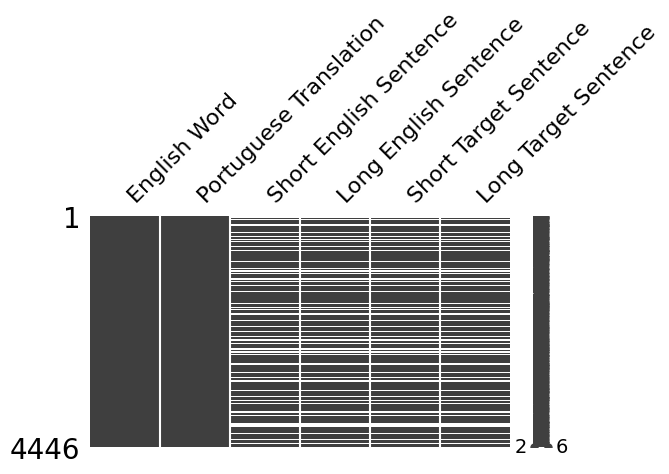

In [23]:
print(matches.count())
msno.matrix(matches, figsize=(6, 3))